<a href="https://colab.research.google.com/github/LampsteR/Stock_Prediction/blob/main/Stock_Prediction_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Right now I am using MACD, RSI, EMA, Volume, Nifty 50 index, Close
#Evaluation should be done using MAE, RMSE(where large error matters), MAPE, Rsquare

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
#import talib. This module was not found that's why we build manual indicators

def calculate_rsi(prices, period=14):
    """Calculate RSI manually"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_ema(prices, span):
    """Calculate Exponential Moving Average"""
    return prices.ewm(span=span).mean()

def calculate_macd(prices, fast=12, slow=26, signal=9):
    """Calculate MACD manually"""
    ema_fast = calculate_ema(prices, fast)
    ema_slow = calculate_ema(prices, slow)
    macd_line = ema_fast - ema_slow
    signal_line = calculate_ema(macd_line, signal)
    histogram = macd_line - signal_line
    return macd_line, signal_line, histogram

def calculate_atr(high, low, close, period=14):
    """Calculate Average True Range (ATR)"""
    high_low = high - low
    high_close = np.abs(high - close.shift())
    low_close = np.abs(low - close.shift())

    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = true_range.rolling(window=period).mean()
    return atr

def gather_stock_data(i):
    """Gather Infosys and Nifty 50 data for past 10 years"""

    # Define date range (past 10 years)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=5*365)#Change duration from here

    print(f"Fetching data from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

    # Fetch Infosys data (INFY.NS for NSE)
    print("Fetching Infosys data...")
    infosys = yf.download(i, start=start_date, end=end_date, progress=False)

    # Fetch Nifty 50 data (^NSEI for Nifty 50 index)
    print("Fetching Nifty 50 data...")
    nifty50 = yf.download('^NSEI', start=start_date, end=end_date, progress=False)

    return infosys, nifty50

def engineer_features(infosys_data, nifty50_data):
    """Perform feature engineering on the stock data"""

    # Create a DataFrame from the data
    df = pd.DataFrame()
    df['Date'] = infosys_data.index
    df['Open'] = infosys_data['Open'].values
    df['High'] = infosys_data['High'].values
    df['Low'] = infosys_data['Low'].values
    df['Close'] = infosys_data['Close'].values
    df['Volume'] = infosys_data['Volume'].values

    # # Add Nifty 50 close price
    # nifty_close = nifty50_data['Close'].reindex(infosys_data.index)
    # df['Nifty50_Close'] = nifty_close.values

    # print("Calculating technical indicators...")

    # # Convert close prices to pandas Series for calculations
    # close_prices = pd.Series(df['Close'].values, index=df.index)
    # high_prices = pd.Series(df['High'].values, index=df.index)
    # low_prices = pd.Series(df['Low'].values, index=df.index)

    # # Calculate RSI
    # df['RSI'] = calculate_rsi(close_prices)

    # # Calculate MACD
    # macd, macd_signal, macd_histogram = calculate_macd(close_prices)
    # df['MACD'] = macd.values
    # #df['MACD_Signal'] = macd_signal.values
    # df['MACD_Histogram'] = macd_histogram.values

    # '''I am using both MACD and MACD Histogram, they are both co related . But LSTM models can understand feature correlation. Don't use them wiht Linear Models '''

    # # Calculate Exponential Moving Averages
    # periods = [10, 21, 50]#initial periods:- 12, 26, 50, 200
    # for period in periods:
    #     df[f'EMA_{period}'] = calculate_ema(close_prices, period).values


    # # Calculate ATR (Average True Range)
    # df['ATR'] = calculate_atr(high_prices, low_prices, close_prices).values


    # Remove rows with NaN values (due to technical indicators calculation)
    #df.dropna(inplace=True)
    '''#Dropping NaN values might hinder our sequential Data that's why it's better to interpolate'''
    df.interpolate(method='linear', inplace=True)
    '''We can also try different interpolations. Time series based which is good for non-volatile data'''



    # Reset index
    df.reset_index(drop=True, inplace=True)

    #df_new = df.drop(['Open', 'Low', 'High'], axis = 1)#Axis = 1 means coloumn or dp.drop(coloumns = ['A', 'B']) would have done the same

    return df

def main(i):
    """Main function to execute the data gathering and feature engineering"""

    try:
        # Gather stock data
        infosys_data, nifty50_data = gather_stock_data(i)

        print(f"Infosys data shape: {infosys_data.shape}")
        print(f"Nifty 50 data shape: {nifty50_data.shape}")

        # Perform feature engineering
        engineered_df = engineer_features(infosys_data, nifty50_data)

        print(f"\nFinal dataset shape: {engineered_df.shape}")
        print(f"Date range: {engineered_df['Date'].min()} to {engineered_df['Date'].max()}")

        # Display column names
        print(f"\nColumns in the dataset:")
        for col in engineered_df.columns:
            print(f"- {col}")

        # Display first few rows
        print(f"\nFirst 5 rows of the engineered dataset:")
        print(engineered_df.head())

        # Display basic statistics
        print(f"\nBasic statistics:")
        print(engineered_df.describe())

        '''
        # Save to CSV
        filename = f'infosys_engineered_data_{datetime.now().strftime("%Y%m%d")}.csv'
        engineered_df.to_csv(filename, index=False)
        print(f"\nData saved to: {filename}")
        '''
        return engineered_df #Final Data File

    except Exception as e:
        print(f"Error: {e}")
        return None


        '''Independent Function''''''Make a different file for this'''
def target_and_shifting(df,n):
    df['Target_Price'] = df['Close'].shift(-n)
    df = df.drop(['Close'], axis=1)
    df = df[:-n]#This will give every rows except last n rows.

    return df
# Required libraries installation command (run this first):
# pip install yfinance pandas numpy


#Sliding Window Creation
'''This is creating an array which contains all 60 days'''
def create_lookback_sequences(df, target_col, lookback_window):
    df = df.drop(columns=['Date'])#since we don't need to feed it to the model
    X, y = [], []
    for i in range(lookback_window, len(df)):
        X.append(df.iloc[i-lookback_window:i].drop(columns=[target_col]).values)
        y.append(df.iloc[i-1][target_col])


    return np.array(X), np.array(y)


#Splitting Data- Chronological Split
'''This will divide the numpy array which contains all the 60 days into first 80 percent as train'''
def train_test_split(X, y, train_size, val_size, lookback_days):
    # split_index = int(len(X) * train_size)
    # X_train = X[:split_index]
    # X_test = X[split_index:]
    # y_train = y[:split_index]
    # y_test = y[split_index:]
    '''Above code has a problem of overlapping time period, which can cause data leakage. So we are going
to use something called Gap shifting, which will does solve the problem to an extent, but there will always
be a time indexing issue which can't be solved with few lines of code for now'''


    '''Below code was done in order to check Nan values in my numpy array'''
    # # Check NaN values for X array
    # print("=== NaN Analysis for X Array ===")
    # print(f"X shape: {X.shape}")
    # print(f"Total NaN values in X: {np.isnan(X).sum()}")
    # print(f"NaN percentage in X: {(np.isnan(X).sum() / X.size) * 100:.2f}%")

    # if X.ndim == 1:
    #     print(f"Positions with NaN in X: {np.where(np.isnan(X))[0]}")
    # else:
    #     print(f"NaN count per row in X: {np.isnan(X).sum(axis=1)}")
    #     print(f"NaN count per column in X: {np.isnan(X).sum(axis=0)}")
    #     print(f"Rows with NaN in X: {np.any(np.isnan(X), axis=1).sum()}")
    #     print(f"Columns with NaN in X: {np.any(np.isnan(X), axis=0).sum()}")

    # # Check NaN values for y array
    # print("\n=== NaN Analysis for y Array ===")
    # print(f"y shape: {y.shape}")
    # print(f"Total NaN values in y: {np.isnan(y).sum()}")
    # print(f"NaN percentage in y: {(np.isnan(y).sum() / y.size) * 100:.2f}%")

    # if y.ndim == 1:
    #     print(f"Positions with NaN in y: {np.where(np.isnan(y))[0]}")
    # else:
    #     print(f"NaN count per row in y: {np.isnan(y).sum(axis=1)}")
    #     print(f"NaN count per column in y: {np.isnan(y).sum(axis=0)}")
    #     print(f"Rows with NaN in y: {np.any(np.isnan(y), axis=1).sum()}")
    #     print(f"Columns with NaN in y: {np.any(np.isnan(y), axis=0).sum()}")




    # Calculate split indices
    train_end = int(len(X) * train_size)
    val_end = int(len(X) * (train_size + val_size))

    # Add gaps to prevent overlap
    gap = lookback_days

    # Split with gaps
    X_train = X[:train_end]
    X_val = X[train_end + gap:val_end]
    X_test = X[val_end + gap:]

    y_train = y[:train_end]
    y_val = y[train_end + gap:val_end]
    y_test = y[val_end + gap:]

    return X_train, X_test, X_val, y_train, y_test, y_val


#Now Scaling the data using MinMaxScaler(-1to1)
def scale_data(X_train, X_test, X_val, y_train, y_test, y_val):

#''' ************************************************************************** '''

    # print('*************************************************')
    # # Before applying MinMaxScaler, check each feature:
    # for i in range(X_train.shape[-1]):  # last dimension = features
    #     feature_data = X_train[:, :, i]  # assuming 3D: (samples, timesteps, features)
    #     min_val = feature_data.min()
    #     max_val = feature_data.max()
    #     if min_val == max_val:
    #         print(f"Feature {i}: ZERO RANGE! min={min_val}, max={max_val}")
    #     else:
    #         print(f"Feature {i}: min={min_val}, max={max_val}")
    # print('***************************************************')


 #'''***********************************************************************************'''
    # Scale X data
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    X_val_scaled = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

    # Scale y data
    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()
    y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()


    return X_train_scaled, X_test_scaled, X_val_scaled, y_train_scaled, y_test_scaled, y_val_scaled, scaler_X, scaler_y



#Model Architecture
'''
        Input: (60, 9)
        ↓
        LSTM(64, return_sequences=True, activation='tanh')
        ↓
        Dropout(0.2)
        ↓
        LSTM(32, activation='tanh')
        ↓
        Dropout(0.2)
        ↓
        Dense(16, activation='relu')
        ↓
        Dense(1, activation='tanh') ← because target is scaled to (-1, 1)
'''
'''We have used 2 LSTM and 2 dense layers, we are using tanh as our output activation
function, and tanh for Dense 1 Layer.
*In pytorch you can use any sequence length as they are able to work on any length.
they are sequence agnostic.
'''
# model.py

# ========================= EDITABLE VARIABLES =========================
INPUT_SIZE = 4
SEQUENCE_LENGTH = 30
HIDDEN_SIZE_1 = 256
HIDDEN_SIZE_2 = 128
HIDDEN_SIZE_3 = 64
DENSE_SIZE = 32
OUTPUT_SIZE = 1
DROPOUT_RATE = 0.3
# ======================================================================

import torch
import torch.nn as nn

class StackedLSTM(nn.Module):
    def __init__(self, input_size=INPUT_SIZE, hidden_size1=HIDDEN_SIZE_1,
                 hidden_size2=HIDDEN_SIZE_2, hidden_size3=HIDDEN_SIZE_3, dense_size=DENSE_SIZE,
                 output_size=OUTPUT_SIZE, dropout_rate=DROPOUT_RATE):
        super(StackedLSTM, self).__init__()

        # First LSTM layer (returns sequences)
        self.lstm1 = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size1,
                            batch_first=True)

        # Dropout layer
        self.dropout1 = nn.Dropout(dropout_rate)

        # Second LSTM layer (doesn't return sequences - only last output)
        self.lstm2 = nn.LSTM(input_size=hidden_size1,
                            hidden_size=hidden_size2,
                            batch_first=True)

        # Dropout layer
        self.dropout2 = nn.Dropout(dropout_rate)

        #Third LSTM Layer
        self.lstm3 = nn.LSTM(input_size=hidden_size2,
                            hidden_size=hidden_size3,
                            batch_first=True)

        # Dropout layer
        self.dropout3 = nn.Dropout(dropout_rate)

        # Dense layers
        self.dense1 = nn.Linear(hidden_size3, dense_size)
        self.dense2 = nn.Linear(dense_size, output_size)

        # Activation functions
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()


    def forward(self, x):
        # First LSTM layer - returns all sequences
        lstm1_out, _ = self.lstm1(x)
        lstm1_out = self.dropout1(lstm1_out)

        # Second LSTM layer - return all sequence
        lstm2_out, _ = self.lstm2(lstm1_out)
        lstm2_out = self.dropout2(lstm2_out)

        # Third LSTM layer - only use the last output
        lstm3_out, _ = self.lstm3(lstm2_out)


        # # Take only the last time step output
        lstm3_last = lstm3_out[:, -1, :]
        lstm3_last = self.dropout2(lstm3_last)

        # Dense layers
        dense1_out = self.tanh(self.dense1(lstm3_last))
        #output = self.tanh(self.dense2(dense1_out))#self.tanh(self.dense2(dense1_out))

        #removing tanh and giving linear output
        output = self.dense2(dense1_out)

        return output

def get_model():
    """Factory function to create and return the model"""
    model = StackedLSTM()
    return model

def count_parameters(model):
    """Count total trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# ***************************************************************************************.  #



#Training Model
'''In the following code, we are loading data, and converting them into torch loaders
for LSTM model, which is required.
'''

# train.py

# ========================= EDITABLE VARIABLES =========================
# Training parameters
BATCH_SIZE = 32
LEARNING_RATE = 0.0005
NUM_EPOCHS = 1000
WEIGHT_DECAY = 1e-5
PATIENCE = 50 # Early stopping patience
MIN_DELTA = 1e-4  # Minimum change for early stopping
GRADIENT_CLIP_VALUE = 2 #Gradient Clipping. Should be between 1 and 5

# # Data paths (adjust according to your data structure)
# TRAIN_DATA_PATH = "train_data.pt"  # Path to your training data
# VAL_DATA_PATH = "val_data.pt"      # Path to your validation data
# TEST_DATA_PATH = "test_data.pt"    # Path to your test data

# Model saving

CHECKPOINT_PATH = "/content/models"  #

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Logging
PRINT_EVERY = 10  # Print loss every N epochs
SAVE_EVERY = 25   # Save checkpoint every N epochs
# ======================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import os
import time

class EarlyStopping:
    def __init__(self, patience=PATIENCE, min_delta=MIN_DELTA):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience

def load_data(X_train_np, y_train_np, X_val_np, y_val_np, X_test_np, y_test_np):
    """
    Load data from numpy arrays and convert to PyTorch tensors

    Args:
        X_train_np: Training features (numpy array)
        y_train_np: Training targets (numpy array)
        X_val_np: Validation features (numpy array)
        y_val_np: Validation targets (numpy array)
        X_test_np: Test features (numpy array)
        y_test_np: Test targets (numpy array)

    Returns:
        Tuple of (train_data, val_data, test_data)
    """
    print("Converting numpy arrays to PyTorch tensors...")

    # Convert numpy arrays to PyTorch tensors
    X_train = torch.FloatTensor(X_train_np)
    y_train = torch.FloatTensor(y_train_np)

    X_val = torch.FloatTensor(X_val_np)
    y_val = torch.FloatTensor(y_val_np)

    X_test = torch.FloatTensor(X_test_np)
    y_test = torch.FloatTensor(y_test_np)

    # Ensure y has correct shape for loss function
    if len(y_train.shape) == 1:
        y_train = y_train.unsqueeze(1)  # (N,) -> (N, 1)
    if len(y_val.shape) == 1:
        y_val = y_val.unsqueeze(1)      # (N,) -> (N, 1)
    if len(y_test.shape) == 1:
        y_test = y_test.unsqueeze(1)    # (N,) -> (N, 1)

    print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Validation data shape: X={X_val.shape}, y={y_val.shape}")
    print(f"Test data shape: X={X_test.shape}, y={y_test.shape}")

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

def create_data_loaders(train_data, val_data, test_data):
    """Create data loaders"""
    X_train, y_train = train_data
    X_val, y_val = val_data
    X_test, y_test = test_data

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, test_loader

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    num_batches = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()

        # Gradient Clipping, this will stop explosive gradients.
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRADIENT_CLIP_VALUE)

        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    return total_loss / num_batches

def validate_epoch(model, val_loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
            num_batches += 1

    return total_loss / num_batches

def save_checkpoint(model, optimizer, epoch, train_loss, val_loss, filepath):
    """Save training checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
    }
    torch.save(checkpoint, filepath)

def load_checkpoint(model, optimizer, filepath):
    """Load training checkpoint"""
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['train_loss'], checkpoint['val_loss']


def train_model(X_train_np, y_train_np, X_val_np, y_val_np, X_test_np, y_test_np, model):
    """Main training function - accepts all numpy arrays directly"""
    print(f"Using device: {DEVICE}")


    '''   # Check where NaN values are:
    print("Debugging*****************************************")
    print(f"Total NaN values in X_train: {np.isnan(X_train_np).sum()}")
    print(f"NaN locations: {np.where(np.isnan(X_train_np))}")''' #For Debuggng

    # Load data from numpy arrays
    train_data, val_data, test_data = load_data(X_train_np, y_train_np, X_val_np, y_val_np, X_test_np, y_test_np)

    '''This was used to find the nan values error'''
    # print(f"X_train_np: NaN={np.isnan(X_train_np).any()}, Inf={np.isinf(X_train_np).any()}")
    # print(f"y_train_np: NaN={np.isnan(y_train_np).any()}, Inf={np.isinf(y_train_np).any()}")
    # print(f"X_train_np range: {X_train_np.min()} to {X_train_np.max()}")
    # print(f"y_train_np range: {y_train_np.min()} to {y_train_np.max()}")




    train_loader, val_loader, test_loader = create_data_loaders(train_data, val_data, test_data)


    # Initialize model
    print(f"Model parameters: {count_parameters(model):,}")

    # ADD THIS LINE:
    model = model.to(DEVICE)  #Move model to GPU

    # Loss function and optimizer
    #criterion = nn.MSELoss()
    criterion = nn.SmoothL1Loss()  # New: Huber Loss
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    # Early stopping
    early_stopping = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)

    # Training history
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    print(f"\nStarting training for {NUM_EPOCHS} epochs...")
    start_time = time.time()



    for epoch in range(NUM_EPOCHS):
        # Training
        train_loss = train_epoch(model, train_loader, criterion, optimizer, DEVICE)

        # Validation
        val_loss = validate_epoch(model, val_loader, criterion, DEVICE)

        # Record losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Print progress
        if (epoch + 1) % PRINT_EVERY == 0:
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss

            # Debug prints
            #print(f"CHECKPOINT_PATH: {CHECKPOINT_PATH}")
            os.makedirs(CHECKPOINT_PATH, exist_ok=True)
            best_model_path = f"{CHECKPOINT_PATH}/best_model.pth"
            #print(f"Saving to: {best_model_path}")

            torch.save(model.state_dict(), best_model_path)
            #print(f'New best model saved with validation loss: {val_loss:.6f}')



        # Save checkpoint
        if (epoch + 1) % SAVE_EVERY == 0:
            checkpoint_file = f"{CHECKPOINT_PATH}/checkpoint_epoch_{epoch+1}.pth"
            save_checkpoint(model, optimizer, epoch, train_loss, val_loss, checkpoint_file)


        # Early stopping
        if early_stopping(val_loss):
            print(f'Early stopping at epoch {epoch+1}')
            break

    training_time = time.time() - start_time
    print(f"\nTraining completed in {training_time:.2f} seconds")
    print(f"Best validation loss: {best_val_loss:.6f}")

    # Load best model for final evaluation
    best_model_path = f"{CHECKPOINT_PATH}/best_model.pth"
    model.load_state_dict(torch.load(best_model_path))

    # # Test evaluation (if test data available)
    # if test_loader is not None:
    #     test_loss = validate_epoch(model, test_loader, criterion, DEVICE)
    #     print(f"Test loss: {test_loss:.6f}")

    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_history.png')
    plt.show()

    return model, train_losses, val_losses

#     *************************************************************************************************    #







# New section

In [ ]:
# # '''Below will be the Evaluation Part of the File
# # We are using MAE, RMSE, R square matrices.'''

# # #Evaluation


# # import numpy as np
# # import matplotlib.pyplot as plt
# # from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# # import torch
# # from torch.utils.data import DataLoader, TensorDataset


# # def setup_gpu():
# #     """Initialize GPU configuration and display system info."""
# #     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# #     if torch.cuda.is_available():
# #         print(f"Using GPU: {torch.cuda.get_device_name()}")
# #         print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
# #         torch.cuda.empty_cache()
# #     else:
# #         print("Using CPU")
# #     return device


# # def numpy_to_torch_tensors(X_test, y_test):
# #     """
# #     Convert numpy arrays to PyTorch tensors.

# #     Args:
# #         X_test: numpy array of scaled features (already in sequence format)
# #         y_test: numpy array of scaled targets

# #     Returns:
# #         X_tensor: PyTorch tensor
# #         y_tensor: PyTorch tensor
# #         device: torch device
# #     """
# #     device = setup_gpu()

# #     print(f"Input data shapes - X_test: {X_test.shape}, y_test: {y_test.shape}")

# #     # Convert to tensors and move to device
# #     X_tensor = torch.FloatTensor(X_test).to(device)
# #     y_tensor = torch.FloatTensor(y_test).to(device)

# #     return X_tensor, y_tensor, device


# # def prepare_dataloader(X_test, y_test, batch_size=32):
# #     """
# #     Prepare DataLoader from numpy arrays.

# #     Args:
# #         X_test: numpy array of scaled features (already in sequence format)
# #         y_test: numpy array of scaled targets
# #         batch_size: batch size for DataLoader

# #     Returns:
# #         test_loader: DataLoader for test data
# #         device: torch device
# #     """
# #     device = setup_gpu()

# #     print(f"Input data shapes - X_test: {X_test.shape}, y_test: {y_test.shape}")

# #     # Convert to PyTorch tensors
# #     X_test_tensor = torch.FloatTensor(X_test)
# #     y_test_tensor = torch.FloatTensor(y_test)

# #     # Create dataset and dataloader
# #     test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# #     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# #     return test_loader, device


# # def make_predictions_with_loader(model, test_loader, device):
# #     """Generate predictions using DataLoader."""
# #     model.eval()
# #     model.to(device)

# #     all_predictions = []
# #     all_targets = []

# #     with torch.no_grad():
# #         for batch_X, batch_y in test_loader:
# #             batch_X = batch_X.to(device)
# #             batch_y = batch_y.to(device)

# #             # Make predictions
# #             batch_pred = model(batch_X)

# #             # Store predictions and targets
# #             all_predictions.append(batch_pred.cpu())
# #             all_targets.append(batch_y.cpu())

# #     # Concatenate all batches
# #     y_pred_scaled = torch.cat(all_predictions, dim=0)
# #     y_test_scaled = torch.cat(all_targets, dim=0)

# #     print(f"Prediction tensor shape: {y_pred_scaled.shape}")
# #     print(f"Target tensor shape: {y_test_scaled.shape}")

# #     return y_pred_scaled, y_test_scaled


# # def make_predictions_with_tensors(model, X_tensor, device):
# #     """Generate predictions using tensors directly."""
# #     model.eval()
# #     model.to(device)

# #     with torch.no_grad():
# #         y_pred_scaled = model(X_tensor)

# #     print(f"Prediction tensor shape: {y_pred_scaled.shape}")
# #     return y_pred_scaled


# # def process_predictions(y_pred_scaled, y_test_scaled, scaler_y):
# #     """Convert predictions to numpy and inverse transform."""
# #     # Convert to numpy arrays
# #     if isinstance(y_pred_scaled, torch.Tensor):
# #         y_pred_scaled_np = y_pred_scaled.detach().cpu().numpy()
# #     else:
# #         y_pred_scaled_np = y_pred_scaled

# #     if isinstance(y_test_scaled, torch.Tensor):
# #         y_test_scaled_np = y_test_scaled.detach().cpu().numpy()
# #     else:
# #         y_test_scaled_np = y_test_scaled

# #     # Clear GPU memory after moving to CPU
# #     if torch.cuda.is_available():
# #         torch.cuda.empty_cache()

# #     # Flatten if needed
# #     if y_pred_scaled_np.ndim > 1:
# #         y_pred_scaled_np = y_pred_scaled_np.flatten()
# #     if y_test_scaled_np.ndim > 1:
# #         y_test_scaled_np = y_test_scaled_np.flatten()

# #     # Inverse transform to get actual stock prices
# #     y_pred = scaler_y.inverse_transform(y_pred_scaled_np.reshape(-1, 1)).flatten()
# #     y_test_original = scaler_y.inverse_transform(y_test_scaled_np.reshape(-1, 1)).flatten()

# #     return y_pred, y_test_original


# # def calculate_metrics(y_test_original, y_pred):
# #     """Calculate evaluation metrics."""
# #     mae = mean_absolute_error(y_test_original, y_pred)
# #     rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
# #     r2 = r2_score(y_test_original, y_pred)

# #     # Handle division by zero in MAPE calculation
# #     mask = y_test_original != 0
# #     mape = np.mean(np.abs((y_test_original[mask] - y_pred[mask]) / y_test_original[mask])) * 100

# #     residuals = y_test_original - y_pred

# #     metrics = {
# #         'mae': mae,
# #         'rmse': rmse,
# #         'r2': r2,
# #         'mape': mape,
# #         'residuals': residuals
# #     }

# #     return metrics


# # def print_evaluation_results(metrics):
# #     """Print evaluation results in a formatted way."""
# #     print("\nStock Price Prediction Results:")
# #     print("=" * 40)
# #     print(f"Mean Absolute Error (MAE): ${metrics['mae']:.2f}")
# #     print(f"Root Mean Square Error (RMSE): ${metrics['rmse']:.2f}")
# #     print(f"R-squared (R²): {metrics['r2']:.4f}")
# #     print(f"Mean Absolute Percentage Error (MAPE): {metrics['mape']:.2f}%")
# #     print("=" * 40)

# #     print("\nDetailed Analysis:")
# #     print("-" * 30)
# #     print(f"Mean residual: ${np.mean(metrics['residuals']):.2f}")
# #     print(f"Std of residuals: ${np.std(metrics['residuals']):.2f}")
# #     print(f"Min residual: ${np.min(metrics['residuals']):.2f}")
# #     print(f"Max residual: ${np.max(metrics['residuals']):.2f}")


# # def create_price_comparison_plot(y_test_original, y_pred):
# #     """Create actual vs predicted prices over time plot."""
# #     plt.figure(figsize=(15, 8))

# #     # Create day indices
# #     days = range(len(y_test_original))

# #     # Plot actual and predicted prices
# #     plt.plot(days, y_test_original, label='Actual Prices', color='blue', linewidth=2, alpha=0.8)
# #     plt.plot(days, y_pred, label='Predicted Prices', color='red', linewidth=2, alpha=0.8)

# #     plt.title('Stock Price Prediction: Actual vs Predicted Prices Over Time', fontsize=16, fontweight='bold')
# #     plt.xlabel('Days', fontsize=12)
# #     plt.ylabel('Stock Price ($)', fontsize=12)
# #     plt.legend(fontsize=12)
# #     plt.grid(True, alpha=0.3)

# #     # Add some styling
# #     plt.tight_layout()
# #     plt.show()


# # # COMMENTED OUT EVALUATION PLOTS - keeping for future use if needed
# # """
# # def create_evaluation_plots(y_test_original, y_pred, metrics):
# #     # Create comprehensive evaluation plots.
# #     residuals = metrics['residuals']

# #     # Create main figure with subplots
# #     fig, axes = plt.subplots(2, 2, figsize=(15, 12))
# #     fig.suptitle('Stock Price Prediction Results', fontsize=16, fontweight='bold')

# #     # 1. Actual vs Predicted scatter plot
# #     axes[0, 0].scatter(y_test_original, y_pred, alpha=0.6, color='blue', s=30)
# #     axes[0, 0].plot([y_test_original.min(), y_test_original.max()],
# #                     [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
# #     axes[0, 0].set_xlabel('Actual Stock Price ($)')
# #     axes[0, 0].set_ylabel('Predicted Stock Price ($)')
# #     axes[0, 0].set_title(f'Actual vs Predicted\nR² = {metrics["r2"]:.4f}')
# #     axes[0, 0].grid(True, alpha=0.3)

# #     # 2. Residuals plot
# #     axes[0, 1].scatter(y_pred, residuals, alpha=0.6, color='green', s=30)
# #     axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
# #     axes[0, 1].set_xlabel('Predicted Stock Price ($)')
# #     axes[0, 1].set_ylabel('Residuals ($)')
# #     axes[0, 1].set_title('Residuals Plot')
# #     axes[0, 1].grid(True, alpha=0.3)

# #     # 3. Time series comparison
# #     n_points = min(100, len(y_test_original))
# #     indices = range(n_points)
# #     axes[1, 0].plot(indices, y_test_original[:n_points], label='Actual', color='blue', linewidth=2)
# #     axes[1, 0].plot(indices, y_pred[:n_points], label='Predicted', color='red', linewidth=2, alpha=0.7)
# #     axes[1, 0].set_xlabel('Time Steps')
# #     axes[1, 0].set_ylabel('Stock Price ($)')
# #     axes[1, 0].set_title(f'Price Comparison (First {n_points} points)')
# #     axes[1, 0].legend()
# #     axes[1, 0].grid(True, alpha=0.3)

# #     # 4. Error distribution histogram
# #     axes[1, 1].hist(residuals, bins=50, alpha=0.7, color='purple', edgecolor='black')
# #     axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
# #     axes[1, 1].set_xlabel('Residuals ($)')
# #     axes[1, 1].set_ylabel('Frequency')
# #     axes[1, 1].set_title('Error Distribution')
# #     axes[1, 1].grid(True, alpha=0.3)

# #     plt.tight_layout()
# #     plt.show()


# # def create_detailed_plots(y_test_original, y_pred, metrics):
# #     # Create detailed time series and error plots.
# #     residuals = metrics['residuals']

# #     plt.figure(figsize=(12, 8))

# #     # Complete time series comparison
# #     plt.subplot(2, 1, 1)
# #     plt.plot(y_test_original, label='Actual', color='blue', alpha=0.8)
# #     plt.plot(y_pred, label='Predicted', color='red', alpha=0.8)
# #     plt.title('Complete Time Series: Actual vs Predicted Stock Prices')
# #     plt.xlabel('Sample Index')
# #     plt.ylabel('Stock Price ($)')
# #     plt.legend()
# #     plt.grid(True, alpha=0.3)

# #     # Absolute error over time
# #     plt.subplot(2, 1, 2)
# #     plt.plot(np.abs(residuals), label='Absolute Error', color='orange', alpha=0.8)
# #     plt.title('Absolute Error Over Time')
# #     plt.xlabel('Sample Index')
# #     plt.ylabel('Absolute Error ($)')
# #     plt.legend()
# #     plt.grid(True, alpha=0.3)

# #     plt.tight_layout()
# #     plt.show()
# # """


# # def print_metrics_table(metrics):
# #     """Print metrics in a formatted table."""
# #     print("\nSummary Table:")
# #     print("-" * 20)
# #     metrics_data = [
# #         ('MAE', f"${metrics['mae']:.2f}"),
# #         ('RMSE', f"${metrics['rmse']:.2f}"),
# #         ('R²', f"{metrics['r2']:.4f}"),
# #         ('MAPE (%)', f"{metrics['mape']:.2f}")
# #     ]

# #     for metric_name, value in metrics_data:
# #         print(f"{metric_name:<10}: {value}")


# # def monitor_gpu_memory():
# #     """Monitor and display GPU memory usage."""
# #     if torch.cuda.is_available():
# #         torch.cuda.empty_cache()
# #         allocated = torch.cuda.memory_allocated() / 1e9
# #         reserved = torch.cuda.memory_reserved() / 1e9
# #         print(f"\nGPU Memory Status:")
# #         print(f"Allocated: {allocated:.2f} GB")
# #         print(f"Reserved: {reserved:.2f} GB")


# # def evaluate_lstm_model_with_numpy(model, X_test, y_test, scaler_y,
# #                                    batch_size=32, use_dataloader=True, create_plots=True):
# #     """
# #     Main function to evaluate LSTM model performance using numpy arrays.

# #     Args:
# #         model: Trained PyTorch LSTM model
# #         X_test: numpy array of scaled features (already in sliding window format)
# #         y_test: numpy array of scaled targets
# #         scaler_y: MinMaxScaler for target variable
# #         batch_size: batch size for DataLoader (if use_dataloader=True)
# #         use_dataloader: whether to use DataLoader or direct tensor processing
# #         create_plots: whether to create evaluation plots

# #     Returns:
# #         dict: Dictionary containing all evaluation metrics and results
# #     """
# #     print(f"Evaluating LSTM model with sliding window data")
# #     print(f"Input shapes - X_test: {X_test.shape}, y_test: {y_test.shape}")

# #     if use_dataloader:
# #         # Method 1: Using DataLoader
# #         test_loader, device = prepare_dataloader(X_test, y_test, batch_size)

# #         # Make predictions using DataLoader
# #         y_pred_scaled, y_test_scaled = make_predictions_with_loader(model, test_loader, device)

# #     else:
# #         # Method 2: Using tensors directly
# #         X_tensor, y_tensor, device = numpy_to_torch_tensors(X_test, y_test)

# #         # Make predictions using tensors
# #         y_pred_scaled = make_predictions_with_tensors(model, X_tensor, device)
# #         y_test_scaled = y_tensor

# #     # Process predictions
# #     y_pred, y_test_original = process_predictions(y_pred_scaled, y_test_scaled, scaler_y)

# #     # Calculate metrics
# #     metrics = calculate_metrics(y_test_original, y_pred)

# #     # Print results
# #     print_evaluation_results(metrics)
# #     print_metrics_table(metrics)

# #     # Create plots if requested
# #     if create_plots:
# #         create_price_comparison_plot(y_test_original, y_pred)
# #         # create_evaluation_plots(y_test_original, y_pred, metrics)  # COMMENTED OUT
# #         # create_detailed_plots(y_test_original, y_pred, metrics)    # COMMENTED OUT

# #     # Monitor GPU memory
# #     monitor_gpu_memory()

# #     # Return complete results
# #     results = {
# #         'metrics': metrics,
# #         'predictions': y_pred,
# #         'actual': y_test_original,
# #         'scaled_predictions': y_pred_scaled.detach().cpu().numpy() if isinstance(y_pred_scaled, torch.Tensor) else y_pred_scaled,
# #         'scaled_actual': y_test_scaled.detach().cpu().numpy() if isinstance(y_test_scaled, torch.Tensor) else y_test_scaled
# #     }

# #     return results

# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset
# import warnings
# warnings.filterwarnings('ignore')


# class LSTMEvaluator:
#     """
#     Comprehensive LSTM model evaluator with robust error handling and debugging capabilities.
#     """

#     def __init__(self, model, scaler_X=None, scaler_y=None, device=None):
#         """
#         Initialize evaluator with model and scalers.

#         Args:
#             model: Trained PyTorch LSTM model
#             scaler_X: Scaler used for input features (optional)
#             scaler_y: Scaler used for target variable (required)
#             device: PyTorch device (auto-detected if None)
#         """
#         self.model = model
#         self.scaler_X = scaler_X
#         self.scaler_y = scaler_y
#         self.device = self._setup_device(device)
#         self.debug_info = {}

#         # Validate inputs
#         self._validate_inputs()

#     def _setup_device(self, device=None):
#         """Setup and return appropriate device."""
#         if device is None:
#             device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#         if torch.cuda.is_available():
#             print(f"Using GPU: {torch.cuda.get_device_name()}")
#             torch.cuda.empty_cache()
#         else:
#             print("Using CPU")

#         return device

#     def _validate_inputs(self):
#         """Validate model and scalers."""
#         if self.model is None:
#             raise ValueError("Model cannot be None")

#         if self.scaler_y is None:
#             raise ValueError("Target scaler (scaler_y) is required for inverse transformation")

#         # Ensure model is in evaluation mode
#         self.model.eval()
#         self.model.to(self.device)

#         # Disable gradient computation globally for evaluation
#         for param in self.model.parameters():
#             param.requires_grad = False

#     def _validate_data_shapes(self, X_test, y_test):
#         """Validate and print data shapes for debugging."""
#         print(f"\nData Validation:")
#         print(f"X_test shape: {X_test.shape}")
#         print(f"y_test shape: {y_test.shape}")

#         # Check if data is 3D for LSTM (samples, sequence_length, features)
#         if len(X_test.shape) != 3:
#             raise ValueError(f"X_test must be 3D (samples, sequence_length, features), got shape: {X_test.shape}")

#         # Check if y_test is 1D or 2D
#         if len(y_test.shape) not in [1, 2]:
#             raise ValueError(f"y_test must be 1D or 2D, got shape: {y_test.shape}")

#         # Store shapes for debugging
#         self.debug_info['input_shape'] = X_test.shape
#         self.debug_info['target_shape'] = y_test.shape

#         return True

#     def _prepare_data(self, X_test, y_test, batch_size=32):
#         """Prepare data for evaluation."""
#         # Validate shapes
#         self._validate_data_shapes(X_test, y_test)

#         # Convert to tensors
#         X_tensor = torch.FloatTensor(X_test).to(self.device)

#         # Handle y_test shape properly
#         if len(y_test.shape) == 1:
#             y_tensor = torch.FloatTensor(y_test).unsqueeze(1).to(self.device)
#         else:
#             y_tensor = torch.FloatTensor(y_test).to(self.device)

#         # Create dataset and dataloader
#         dataset = TensorDataset(X_tensor, y_tensor)
#         dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

#         print(f"Created DataLoader with {len(dataset)} samples, batch_size={batch_size}")

#         return dataloader, X_tensor, y_tensor

#     def _make_predictions(self, dataloader):
#         """Generate predictions using the model."""
#         all_predictions = []
#         all_targets = []

#         print("Generating predictions...")

#         with torch.no_grad():
#             for batch_idx, (batch_X, batch_y) in enumerate(dataloader):
#                 # Ensure data is on correct device
#                 batch_X = batch_X.to(self.device)
#                 batch_y = batch_y.to(self.device)

#                 # Make predictions
#                 batch_pred = self.model(batch_X)

#                 # Debug first batch
#                 if batch_idx == 0:
#                     print(f"First batch - Input shape: {batch_X.shape}")
#                     print(f"First batch - Target shape: {batch_y.shape}")
#                     print(f"First batch - Prediction shape: {batch_pred.shape}")
#                     print(f"First batch - Prediction sample: {batch_pred[0].item():.4f}")
#                     print(f"First batch - Target sample: {batch_y[0].item():.4f}")

#                 # Store predictions and targets
#                 all_predictions.append(batch_pred.cpu())
#                 all_targets.append(batch_y.cpu())

#         # Concatenate all batches
#         predictions_scaled = torch.cat(all_predictions, dim=0)
#         targets_scaled = torch.cat(all_targets, dim=0)

#         print(f"Final prediction tensor shape: {predictions_scaled.shape}")
#         print(f"Final target tensor shape: {targets_scaled.shape}")

#         # Store for debugging
#         self.debug_info['predictions_scaled_shape'] = predictions_scaled.shape
#         self.debug_info['targets_scaled_shape'] = targets_scaled.shape

#         return predictions_scaled, targets_scaled

#     def _inverse_transform_predictions(self, predictions_scaled, targets_scaled):
#         """Safely inverse transform predictions and targets."""
#         print("\nInverse transforming predictions...")

#         # Convert to numpy
#         pred_np = predictions_scaled.detach().cpu().numpy()
#         target_np = targets_scaled.detach().cpu().numpy()

#         # Flatten if needed (but carefully)
#         if pred_np.ndim > 1:
#             pred_np = pred_np.reshape(-1, 1)
#         if target_np.ndim > 1:
#             target_np = target_np.reshape(-1, 1)

#         print(f"Pre-inverse transform shapes - Predictions: {pred_np.shape}, Targets: {target_np.shape}")

#         # Debug: Print some raw scaled values
#         print(f"Sample scaled predictions: {pred_np[:5].flatten()}")
#         print(f"Sample scaled targets: {target_np[:5].flatten()}")

#         try:
#             # Inverse transform predictions
#             predictions_original = self.scaler_y.inverse_transform(pred_np).flatten()

#             # Inverse transform targets
#             targets_original = self.scaler_y.inverse_transform(target_np).flatten()

#             print(f"Sample original predictions: {predictions_original[:5]}")
#             print(f"Sample original targets: {targets_original[:5]}")

#             # Validate inverse transformation
#             if np.any(np.isnan(predictions_original)) or np.any(np.isnan(targets_original)):
#                 raise ValueError("NaN values found after inverse transformation")

#             return results

#         except Exception as e:
#             print(f"Error during evaluation: {e}")
#             print(f"Debug info: {self.debug_info}")
#             raise


# def evaluate_lstm_model(model, X_test, y_test, scaler_y, scaler_X=None,
#                        batch_size=32, create_plots=True, verbose=True):
#     """
#     Convenience function to evaluate LSTM model.

#     Args:
#         model: Trained PyTorch LSTM model
#         X_test: Test features (samples, sequence_length, features)
#         y_test: Test targets (samples,) or (samples, 1)
#         scaler_y: Scaler for target variable
#         scaler_X: Scaler for input features (optional)
#         batch_size: Batch size for evaluation
#         create_plots: Whether to create plots
#         verbose: Whether to print detailed results

#     Returns:
#         dict: Evaluation results
#     """
#     evaluator = LSTMEvaluator(model, scaler_X, scaler_y)
#     return evaluator.evaluate(X_test, y_test, batch_size, create_plots, verbose)


# def evaluate_lstm_model_with_numpy(model, X_test, y_test, scaler_y, scaler_X=None,
#                                  batch_size=32, create_plots=True):
#     """
#     Alternative function name for compatibility (without verbose parameter).

#     Args:
#         model: Trained PyTorch LSTM model
#         X_test: Test features (samples, sequence_length, features)
#         y_test: Test targets (samples,) or (samples, 1)
#         scaler_y: Scaler for target variable
#         scaler_X: Scaler for input features (optional)
#         batch_size: Batch size for evaluation
#         create_plots: Whether to create plots

#     Returns:
#         dict: Evaluation results
#     """
#     evaluator = LSTMEvaluator(model, scaler_X, scaler_y)
#     return evaluator.evaluate(X_test, y_test, batch_size, create_plots, verbose=True)


# # Example usage:
# """
# # Example usage with your model
# results = evaluate_lstm_model(
#     model=your_trained_model,
#     X_test=X_test,  # Shape: (samples, sequence_length, features)
#     y_test=y_test,  # Shape: (samples,) or (samples, 1)
#     scaler_y=your_target_scaler,  # The scaler used for target during training
#     scaler_X=your_feature_scaler,  # Optional: scaler for features
#     batch_size=32,
#     create_plots=True,
#     verbose=True
# )

# # Access results
# print(f"Model R²: {results['metrics']['r2']:.4f}")
# print(f"Model MAPE: {results['metrics']['mape']:.2f}%")

# # Alternative usage (matches your function name)
# results = evaluate_lstm_model_with_numpy(
#     model=your_trained_model,
#     X_test=X_test,
#     y_test=y_test,
#     scaler_y=your_target_scaler,
#     scaler_X=your_feature_scaler,
#     batch_size=32,
#     create_plots=True
# )
# """ predictions_original, targets_original

#         except Exception as e:
#             print(f"Error during inverse transformation: {e}")
#             print(f"Scaler parameters: {self.scaler_y.data_min_}, {self.scaler_y.data_max_}")
#             raise

#     def _calculate_metrics(self, y_true, y_pred):
#         """Calculate comprehensive evaluation metrics."""
#         # Basic metrics
#         mae = mean_absolute_error(y_true, y_pred)
#         mse = mean_squared_error(y_true, y_pred)
#         rmse = np.sqrt(mse)

#         # R-squared
#         r2 = r2_score(y_true, y_pred)

#         # MAPE (handle division by zero)
#         mask = y_true != 0
#         if np.sum(mask) > 0:
#             mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
#         else:
#             mape = float('inf')

#         # Additional metrics
#         residuals = y_true - y_pred
#         mean_residual = np.mean(residuals)
#         std_residual = np.std(residuals)

#         # Directional accuracy (for stock prediction)
#         if len(y_true) > 1:
#             true_direction = np.diff(y_true) > 0
#             pred_direction = np.diff(y_pred) > 0
#             directional_accuracy = np.mean(true_direction == pred_direction) * 100
#         else:
#             directional_accuracy = 0

#         metrics = {
#             'mae': mae,
#             'mse': mse,
#             'rmse': rmse,
#             'r2': r2,
#             'mape': mape,
#             'mean_residual': mean_residual,
#             'std_residual': std_residual,
#             'directional_accuracy': directional_accuracy,
#             'residuals': residuals
#         }

#         return metrics

#     def _print_results(self, metrics, y_true, y_pred):
#         """Print comprehensive evaluation results."""
#         print("\n" + "="*60)
#         print("LSTM MODEL EVALUATION RESULTS")
#         print("="*60)

#         print(f"Dataset Size: {len(y_true)} samples")
#         print(f"Price Range: ${np.min(y_true):.2f} - ${np.max(y_true):.2f}")
#         print(f"Mean Price: ${np.mean(y_true):.2f}")

#         print("\nPERFORMANCE METRICS:")
#         print("-" * 30)
#         print(f"Mean Absolute Error (MAE):     ${metrics['mae']:.2f}")
#         print(f"Root Mean Square Error (RMSE): ${metrics['rmse']:.2f}")
#         print(f"Mean Squared Error (MSE):      ${metrics['mse']:.2f}")
#         print(f"R-squared (R²):                {metrics['r2']:.4f}")
#         print(f"Mean Absolute Percentage Error: {metrics['mape']:.2f}%")
#         print(f"Directional Accuracy:          {metrics['directional_accuracy']:.2f}%")

#         print("\nRESIDUAL ANALYSIS:")
#         print("-" * 30)
#         print(f"Mean Residual:                 ${metrics['mean_residual']:.2f}")
#         print(f"Std Residual:                  ${metrics['std_residual']:.2f}")
#         print(f"Min Residual:                  ${np.min(metrics['residuals']):.2f}")
#         print(f"Max Residual:                  ${np.max(metrics['residuals']):.2f}")

#         # Performance interpretation
#         print("\nMODEL PERFORMANCE ASSESSMENT:")
#         print("-" * 30)
#         if metrics['r2'] > 0.8:
#             print("✓ Excellent model performance (R² > 0.8)")
#         elif metrics['r2'] > 0.6:
#             print("✓ Good model performance (R² > 0.6)")
#         elif metrics['r2'] > 0.4:
#             print("⚠ Moderate model performance (R² > 0.4)")
#         else:
#             print("✗ Poor model performance (R² < 0.4)")

#         if metrics['mape'] < 5:
#             print("✓ Excellent prediction accuracy (MAPE < 5%)")
#         elif metrics['mape'] < 10:
#             print("✓ Good prediction accuracy (MAPE < 10%)")
#         elif metrics['mape'] < 20:
#             print("⚠ Moderate prediction accuracy (MAPE < 20%)")
#         else:
#             print("✗ Poor prediction accuracy (MAPE > 20%)")

#     def _create_plots(self, y_true, y_pred, metrics):
#         """Create comprehensive evaluation plots."""
#         fig, axes = plt.subplots(2, 2, figsize=(16, 12))
#         fig.suptitle('LSTM Model Evaluation Results', fontsize=16, fontweight='bold')

#         # 1. Time series comparison
#         days = range(len(y_true))
#         axes[0, 0].plot(days, y_true, label='Actual Prices', color='blue', linewidth=2, alpha=0.8)
#         axes[0, 0].plot(days, y_pred, label='Predicted Prices', color='red', linewidth=2, alpha=0.8)
#         axes[0, 0].set_title(f'Price Prediction Over Time\nMAPE: {metrics["mape"]:.2f}%')
#         axes[0, 0].set_xlabel('Days')
#         axes[0, 0].set_ylabel('Stock Price ($)')
#         axes[0, 0].legend()
#         axes[0, 0].grid(True, alpha=0.3)

#         # 2. Actual vs Predicted scatter
#         axes[0, 1].scatter(y_true, y_pred, alpha=0.6, color='blue', s=20)
#         min_val = min(y_true.min(), y_pred.min())
#         max_val = max(y_true.max(), y_pred.max())
#         axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
#         axes[0, 1].set_xlabel('Actual Stock Price ($)')
#         axes[0, 1].set_ylabel('Predicted Stock Price ($)')
#         axes[0, 1].set_title(f'Actual vs Predicted\nR² = {metrics["r2"]:.4f}')
#         axes[0, 1].grid(True, alpha=0.3)

#         # 3. Residuals plot
#         axes[1, 0].scatter(y_pred, metrics['residuals'], alpha=0.6, color='green', s=20)
#         axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
#         axes[1, 0].set_xlabel('Predicted Stock Price ($)')
#         axes[1, 0].set_ylabel('Residuals ($)')
#         axes[1, 0].set_title('Residuals vs Predicted')
#         axes[1, 0].grid(True, alpha=0.3)

#         # 4. Error distribution
#         axes[1, 1].hist(metrics['residuals'], bins=30, alpha=0.7, color='purple', edgecolor='black')
#         axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
#         axes[1, 1].set_xlabel('Residuals ($)')
#         axes[1, 1].set_ylabel('Frequency')
#         axes[1, 1].set_title('Error Distribution')
#         axes[1, 1].grid(True, alpha=0.3)

#         plt.tight_layout()
#         plt.show()

#         # Additional time series plot (cleaner version)
#         plt.figure(figsize=(15, 8))
#         plt.plot(days, y_true, label='Actual Prices', color='blue', linewidth=2, alpha=0.8)
#         plt.plot(days, y_pred, label='Predicted Prices', color='red', linewidth=2, alpha=0.8)
#         plt.title(f'Stock Price Prediction: Actual vs Predicted\nMAPE: {metrics["mape"]:.2f}%',
#                  fontsize=14, fontweight='bold')
#         plt.xlabel('Days', fontsize=12)
#         plt.ylabel('Stock Price ($)', fontsize=12)
#         plt.legend(fontsize=12)
#         plt.grid(True, alpha=0.3)
#         plt.tight_layout()
#         plt.show()

#     def evaluate(self, X_test, y_test, batch_size=32, create_plots=True, verbose=True):
#         """
#         Main evaluation function.

#         Args:
#             X_test: numpy array of test features (samples, sequence_length, features)
#             y_test: numpy array of test targets (samples,) or (samples, 1)
#             batch_size: batch size for evaluation
#             create_plots: whether to create evaluation plots
#             verbose: whether to print detailed results

#         Returns:
#             dict: Comprehensive evaluation results
#         """
#         try:
#             print("Starting LSTM Model Evaluation...")

#             # Prepare data
#             dataloader, X_tensor, y_tensor = self._prepare_data(X_test, y_test, batch_size)

#             # Make predictions
#             predictions_scaled, targets_scaled = self._make_predictions(dataloader)

#             # Inverse transform
#             predictions_original, targets_original = self._inverse_transform_predictions(
#                 predictions_scaled, targets_scaled
#             )

#             # Calculate metrics
#             metrics = self._calculate_metrics(targets_original, predictions_original)

#             # Print results
#             if verbose:
#                 self._print_results(metrics, targets_original, predictions_original)

#             # Create plots
#             if create_plots:
#                 self._create_plots(targets_original, predictions_original, metrics)

#             # Clean up GPU memory
#             if torch.cuda.is_available():
#                 torch.cuda.empty_cache()

#             # Return comprehensive results
#             results = {
#                 'metrics': metrics,
#                 'predictions': predictions_original,
#                 'actual': targets_original,
#                 'predictions_scaled': predictions_scaled.detach().cpu().numpy(),
#                 'actual_scaled': targets_scaled.detach().cpu().numpy(),
#                 'debug_info': self.debug_info
#             }

#             print(f"\nEvaluation completed successfully!")
#             print(f"Final MAPE: {metrics['mape']:.2f}%")

#             return

# if __name__ == "__main__":
#     # Execute the main function
#     df = main()

#     predicted_day = 1   #How many far days you want to predict
#     lookback_days = 30  #How many days you want to look back
#     train_size = 0.7    #Data Splitting
#     val_size = 0.15     #Validation Splitting

#     df = target_and_shifting(df,predicted_day)
#     # Display column names
#     print(f"\nColumns in the dataset:")
#     for col in df.columns:
#           print(f"- {col}")
#     print(df.head())
#     X, Y = create_lookback_sequences(df, 'Target_Price',lookback_days)      #Creating Sliding Window and are converted into numpy array

#     '''Below is the code to replace those NaN values by using forward filling or interpolation'''
#     # Forward fill (recommended for time series)

#     for i in range(X.shape[0]):
#           for j in range(X.shape[2]):
#               mask = np.isnan(X[i, :, j])
#               if mask.any():
#                   X[i, :, j] = pd.Series(X[i, :, j]).fillna(method='ffill').fillna(method='bfill')


#     X_train, X_test, X_val, y_train, y_test, y_val = train_test_split(X, Y, train_size, val_size, lookback_days)   #Splitting Data

#     X_train_scaled, X_test_scaled, X_val_scaled, y_train_scaled, y_test_scaled, y_val_scaled, scaler_X, scaler_y = scale_data(X_train, X_test, X_val, y_train, y_test, y_val) #Scaling the data

#     # Test the model. From here model.py
#     model = get_model()
#     print("Model Architecture:")
#     print(model)
#     print(f"\nTotal trainable parameters: {count_parameters(model):,}")

#     # Test forward pass
#     sample_input = torch.randn(1, SEQUENCE_LENGTH, INPUT_SIZE)
#     with torch.no_grad():
#         output = model(sample_input)
#         print(f"Output shape: {output.shape}")
#         print(f"Sample output: {output.item():.4f}")


#     #train.py file
#     model, train_losses, val_losses = train_model(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled, model)


#     results = evaluate_lstm_model_with_numpy(
#     model=model,
#     X_test=X_test_scaled,       # Already in sliding window format
#     y_test=y_test_scaled,       # Target values
#     scaler_y=scaler_y,   # Fitted scaler
#     batch_size=32,
#     create_plots=True,
#     verbose=True
#     )

#     # Access results
#     print(f"Final R² Score: {results['metrics']['r2']:.4f}")
#     print(f"MAE: ${results['metrics']['mae']:.2f}")



Fetching data from 2020-07-01 to 2025-06-30
Fetching Infosys data...
Fetching Nifty 50 data...
Infosys data shape: (1239, 5)
Nifty 50 data shape: (1237, 5)

Final dataset shape: (1239, 6)
Date range: 2020-07-01 00:00:00 to 2025-06-30 00:00:00

Columns in the dataset:
- Date
- Open
- High
- Low
- Close
- Volume

First 5 rows of the engineered dataset:
        Date         Open         High          Low        Close   Volume
0 2020-07-01  1902.139145  1933.464945  1901.956265  1913.434814  2503466
1 2020-07-02  1922.535016  1980.156189  1918.876528  1972.976318  3758699
2 2020-07-03  1978.921993  2016.741706  1975.812368  2011.848389  4185208
3 2020-07-06  2016.741458  2076.100335  2016.741458  2069.972412  5190366
4 2020-07-07  2080.765248  2106.100235  2041.573602  2076.100586  5630055

Basic statistics:
                                Date         Open         High          Low  \
count                           1239  1239.000000  1239.000000  1239.000000   
mean   2022-12-26 11:00:08

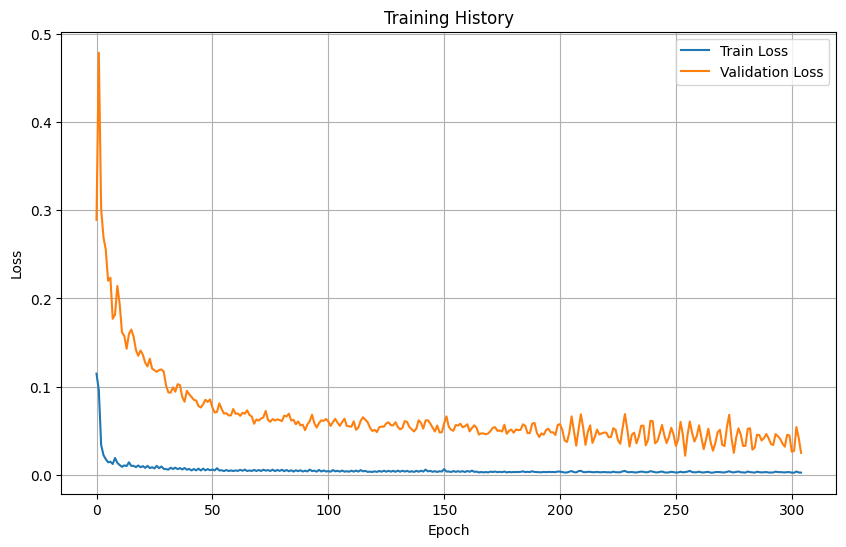

Using GPU: Tesla T4
Starting LSTM Model Evaluation...

Data Validation:
X_test shape: (152, 30, 4)
y_test shape: (152,)
Created DataLoader with 152 samples, batch_size=32
Generating predictions...
First batch - Input shape: torch.Size([32, 30, 4])
First batch - Target shape: torch.Size([32, 1])
First batch - Prediction shape: torch.Size([32, 1])
First batch - Prediction sample: 1.2147
First batch - Target sample: 1.2465
Final prediction tensor shape: torch.Size([152, 1])
Final target tensor shape: torch.Size([152, 1])
Predictions scaled stats:
Mean: 0.8953356742858887
Std: 0.32516616582870483


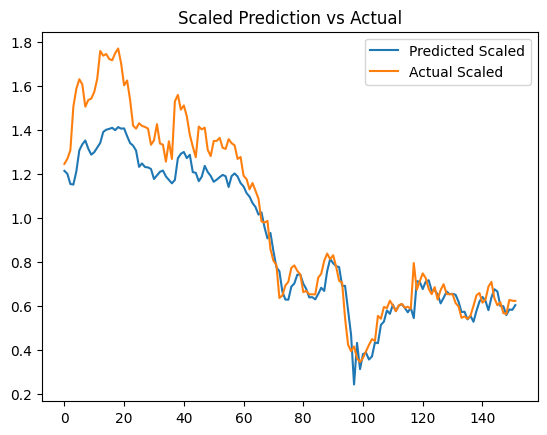


Inverse transforming predictions...
Pre-inverse transform shapes - Predictions: (152, 1), Targets: (152, 1)
Sample scaled predictions: [1.2146759 1.2013919 1.1549985 1.1522744 1.212178 ]
Sample scaled targets: [1.246507  1.2696738 1.3081493 1.506594  1.5880518]
Sample original predictions: [3947.3748 3936.0059 3896.3018 3893.9702 3945.2368]
Sample original targets: [3974.616  3994.4429 4027.3708 4197.2026 4266.9155]

LSTM MODEL EVALUATION RESULTS
Dataset Size: 152 samples
Price Range: 3203.03 - $4423.94
Mean Price: 3751.27

PERFORMANCE METRICS:
------------------------------
Mean Absolute Error (MAE):     91.63
Root Mean Square Error (RMSE): 126.55
Mean Squared Error (MSE):      16015.55
R-squared (R²):                0.8737
Mean Absolute Percentage Error: 2.29%
Directional Accuracy:          54.30%

RESIDUAL ANALYSIS:
------------------------------
Mean Residual:                 77.19
Std Residual:                  100.29
Min Residual:                  -132.83
Max Residual:          

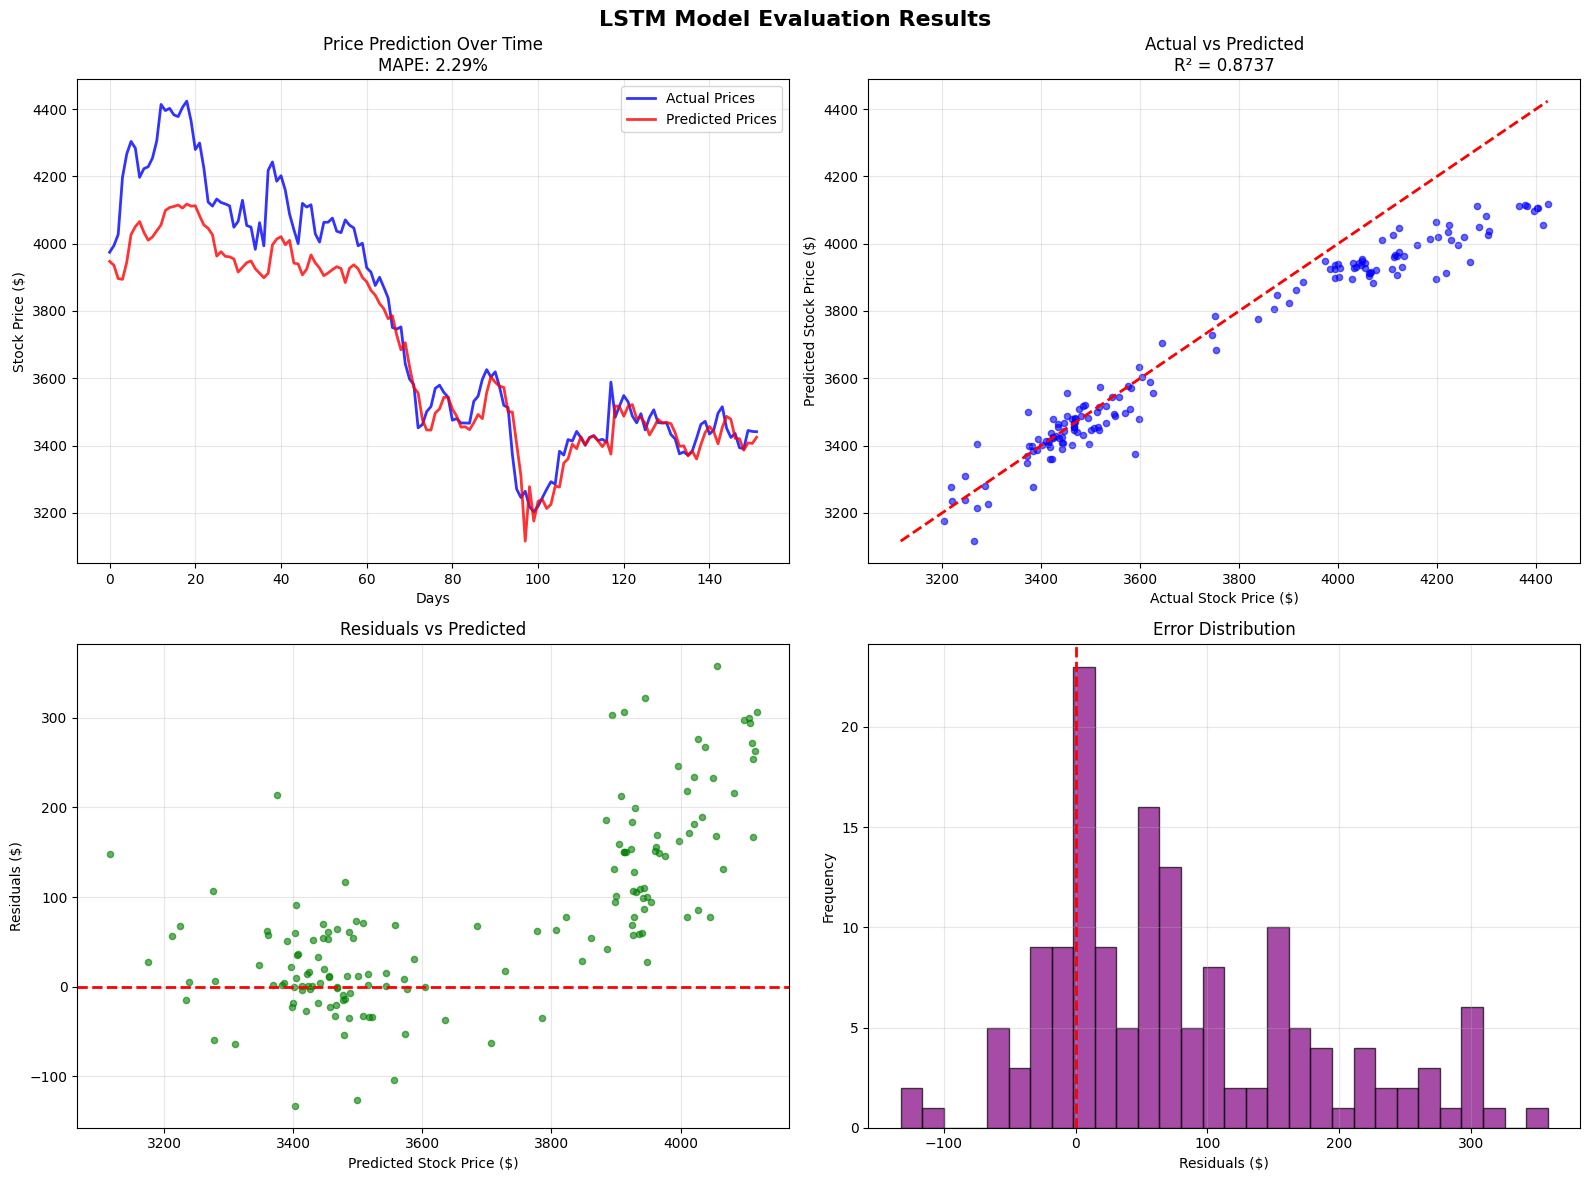

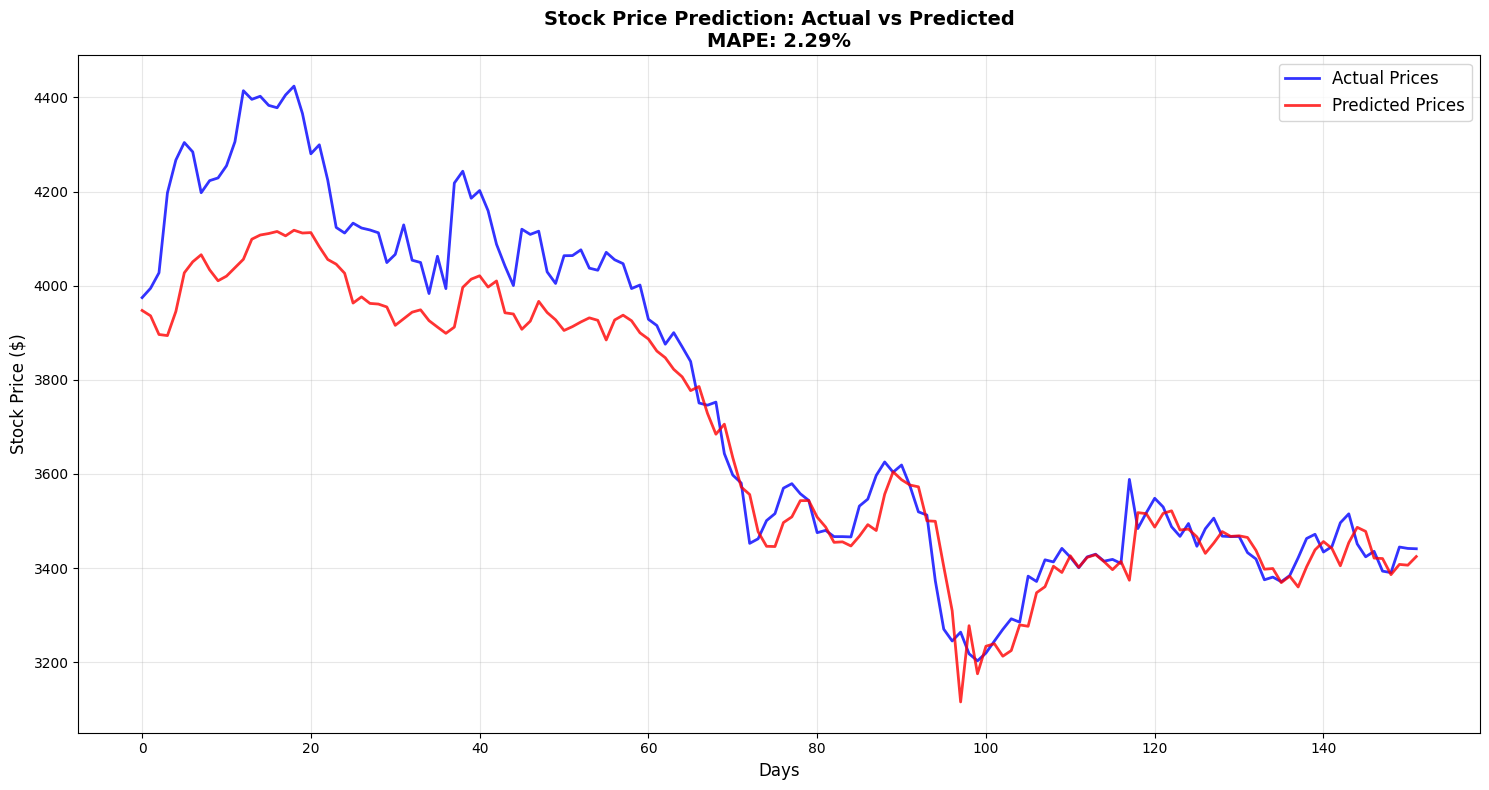


Evaluation completed successfully!
Final MAPE: 2.29%
Model R²: 0.8737
Model MAPE: 2.29%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')


class LSTMEvaluator:
    """
    Comprehensive LSTM model evaluator with robust error handling and debugging capabilities.
    """

    def __init__(self, model, scaler_X=None, scaler_y=None, device=None):
        """
        Initialize evaluator with model and scalers.

        Args:
            model: Trained PyTorch LSTM model
            scaler_X: Scaler used for input features (optional)
            scaler_y: Scaler used for target variable (required)
            device: PyTorch device (auto-detected if None)
        """
        self.model = model
        self.scaler_X = scaler_X
        self.scaler_y = scaler_y
        self.device = self._setup_device(device)
        self.debug_info = {}

        # Validate inputs
        self._validate_inputs()

    def _setup_device(self, device=None):
        """Setup and return appropriate device."""
        if device is None:
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        if torch.cuda.is_available():
            print(f"Using GPU: {torch.cuda.get_device_name()}")
            torch.cuda.empty_cache()
        else:
            print("Using CPU")

        return device

    def _validate_inputs(self):
        """Validate model and scalers."""
        if self.model is None:
            raise ValueError("Model cannot be None")

        if self.scaler_y is None:
            raise ValueError("Target scaler (scaler_y) is required for inverse transformation")

        # Ensure model is in evaluation mode
        self.model.eval()
        self.model.to(self.device)

        # Disable gradient computation globally for evaluation
        for param in self.model.parameters():
            param.requires_grad = False

    def _validate_data_shapes(self, X_test, y_test):
        """Validate and print data shapes for debugging."""
        print(f"\nData Validation:")
        print(f"X_test shape: {X_test.shape}")
        print(f"y_test shape: {y_test.shape}")

        # Check if data is 3D for LSTM (samples, sequence_length, features)
        if len(X_test.shape) != 3:
            raise ValueError(f"X_test must be 3D (samples, sequence_length, features), got shape: {X_test.shape}")

        # Check if y_test is 1D or 2D
        if len(y_test.shape) not in [1, 2]:
            raise ValueError(f"y_test must be 1D or 2D, got shape: {y_test.shape}")

        # Store shapes for debugging
        self.debug_info['input_shape'] = X_test.shape
        self.debug_info['target_shape'] = y_test.shape

        return True

    def _prepare_data(self, X_test, y_test, batch_size=32):
        """Prepare data for evaluation."""
        # Validate shapes
        self._validate_data_shapes(X_test, y_test)

        # Convert to tensors
        X_tensor = torch.FloatTensor(X_test).to(self.device)

        # Handle y_test shape properly
        if len(y_test.shape) == 1:
            y_tensor = torch.FloatTensor(y_test).unsqueeze(1).to(self.device)
        else:
            y_tensor = torch.FloatTensor(y_test).to(self.device)

        # Create dataset and dataloader
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        print(f"Created DataLoader with {len(dataset)} samples, batch_size={batch_size}")

        return dataloader, X_tensor, y_tensor

    def _make_predictions(self, dataloader):
        """Generate predictions using the model."""
        all_predictions = []
        all_targets = []

        print("Generating predictions...")

        with torch.no_grad():
            for batch_idx, (batch_X, batch_y) in enumerate(dataloader):
                # Ensure data is on correct device
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)

                # Make predictions
                batch_pred = self.model(batch_X)

                # Debug first batch
                if batch_idx == 0:
                    print(f"First batch - Input shape: {batch_X.shape}")
                    print(f"First batch - Target shape: {batch_y.shape}")
                    print(f"First batch - Prediction shape: {batch_pred.shape}")
                    print(f"First batch - Prediction sample: {batch_pred[0].item():.4f}")
                    print(f"First batch - Target sample: {batch_y[0].item():.4f}")

                # Store predictions and targets
                all_predictions.append(batch_pred.cpu())
                all_targets.append(batch_y.cpu())

        # Concatenate all batches
        predictions_scaled = torch.cat(all_predictions, dim=0)
        targets_scaled = torch.cat(all_targets, dim=0)

        print(f"Final prediction tensor shape: {predictions_scaled.shape}")
        print(f"Final target tensor shape: {targets_scaled.shape}")

        # Store for debugging
        self.debug_info['predictions_scaled_shape'] = predictions_scaled.shape
        self.debug_info['targets_scaled_shape'] = targets_scaled.shape



        #debugging
        print("Predictions scaled stats:")
        print("Mean:", predictions_scaled.mean().item())
        print("Std:", predictions_scaled.std().item())

        plt.plot(predictions_scaled.cpu().numpy(), label='Predicted Scaled')
        plt.plot(targets_scaled.cpu().numpy(), label='Actual Scaled')
        plt.legend()
        plt.title("Scaled Prediction vs Actual")
        plt.show()


        return predictions_scaled, targets_scaled

    def _inverse_transform_predictions(self, predictions_scaled, targets_scaled):
        """Safely inverse transform predictions and targets."""
        print("\nInverse transforming predictions...")

        # Convert to numpy
        pred_np = predictions_scaled.detach().cpu().numpy()
        target_np = targets_scaled.detach().cpu().numpy()

        # Flatten if needed (but carefully)
        if pred_np.ndim > 1:
            pred_np = pred_np.reshape(-1, 1)
        if target_np.ndim > 1:
            target_np = target_np.reshape(-1, 1)

        print(f"Pre-inverse transform shapes - Predictions: {pred_np.shape}, Targets: {target_np.shape}")

        # Debug: Print some raw scaled values
        print(f"Sample scaled predictions: {pred_np[:5].flatten()}")
        print(f"Sample scaled targets: {target_np[:5].flatten()}")

        try:
            # Inverse transform predictions
            predictions_original = self.scaler_y.inverse_transform(pred_np).flatten()

            # Inverse transform targets
            targets_original = self.scaler_y.inverse_transform(target_np).flatten()

            print(f"Sample original predictions: {predictions_original[:5]}")
            print(f"Sample original targets: {targets_original[:5]}")

            # Validate inverse transformation
            if np.any(np.isnan(predictions_original)) or np.any(np.isnan(targets_original)):
                raise ValueError("NaN values found after inverse transformation")

            return predictions_original, targets_original

        except Exception as e:
            print(f"Error during inverse transformation: {e}")
            print(f"Scaler parameters: {self.scaler_y.data_min_}, {self.scaler_y.data_max_}")
            raise

    def _calculate_metrics(self, y_true, y_pred):
        """Calculate comprehensive evaluation metrics."""
        # Basic metrics
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)

        # R-squared
        r2 = r2_score(y_true, y_pred)

        # MAPE (handle division by zero)
        mask = y_true != 0
        if np.sum(mask) > 0:
            mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
        else:
            mape = float('inf')

        # Additional metrics
        residuals = y_true - y_pred
        mean_residual = np.mean(residuals)
        std_residual = np.std(residuals)

        # Directional accuracy (for stock prediction)
        if len(y_true) > 1:
            true_direction = np.diff(y_true) > 0
            pred_direction = np.diff(y_pred) > 0
            directional_accuracy = np.mean(true_direction == pred_direction) * 100
        else:
            directional_accuracy = 0

        metrics = {
            'mae': mae,
            'mse': mse,
            'rmse': rmse,
            'r2': r2,
            'mape': mape,
            'mean_residual': mean_residual,
            'std_residual': std_residual,
            'directional_accuracy': directional_accuracy,
            'residuals': residuals
        }

        return metrics

    def _print_results(self, metrics, y_true, y_pred):
        """Print comprehensive evaluation results."""
        print("\n" + "="*60)
        print("LSTM MODEL EVALUATION RESULTS")
        print("="*60)

        print(f"Dataset Size: {len(y_true)} samples")
        print(f"Price Range: {np.min(y_true):.2f} - ${np.max(y_true):.2f}")
        print(f"Mean Price: {np.mean(y_true):.2f}")

        print("\nPERFORMANCE METRICS:")
        print("-" * 30)
        print(f"Mean Absolute Error (MAE):     {metrics['mae']:.2f}")
        print(f"Root Mean Square Error (RMSE): {metrics['rmse']:.2f}")
        print(f"Mean Squared Error (MSE):      {metrics['mse']:.2f}")
        print(f"R-squared (R²):                {metrics['r2']:.4f}")
        print(f"Mean Absolute Percentage Error: {metrics['mape']:.2f}%")
        print(f"Directional Accuracy:          {metrics['directional_accuracy']:.2f}%")

        print("\nRESIDUAL ANALYSIS:")
        print("-" * 30)
        print(f"Mean Residual:                 {metrics['mean_residual']:.2f}")
        print(f"Std Residual:                  {metrics['std_residual']:.2f}")
        print(f"Min Residual:                  {np.min(metrics['residuals']):.2f}")
        print(f"Max Residual:                  {np.max(metrics['residuals']):.2f}")

        # Performance interpretation
        print("\nMODEL PERFORMANCE ASSESSMENT:")
        print("-" * 30)
        if metrics['r2'] > 0.8:
            print("✓ Excellent model performance (R² > 0.8)")
        elif metrics['r2'] > 0.6:
            print("✓ Good model performance (R² > 0.6)")
        elif metrics['r2'] > 0.4:
            print("⚠ Moderate model performance (R² > 0.4)")
        else:
            print("✗ Poor model performance (R² < 0.4)")

        if metrics['mape'] < 5:
            print("✓ Excellent prediction accuracy (MAPE < 5%)")
        elif metrics['mape'] < 10:
            print("✓ Good prediction accuracy (MAPE < 10%)")
        elif metrics['mape'] < 20:
            print("⚠ Moderate prediction accuracy (MAPE < 20%)")
        else:
            print("✗ Poor prediction accuracy (MAPE > 20%)")

    def _create_plots(self, y_true, y_pred, metrics):
        """Create comprehensive evaluation plots."""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('LSTM Model Evaluation Results', fontsize=16, fontweight='bold')

        # 1. Time series comparison
        days = range(len(y_true))
        axes[0, 0].plot(days, y_true, label='Actual Prices', color='blue', linewidth=2, alpha=0.8)
        axes[0, 0].plot(days, y_pred, label='Predicted Prices', color='red', linewidth=2, alpha=0.8)
        axes[0, 0].set_title(f'Price Prediction Over Time\nMAPE: {metrics["mape"]:.2f}%')
        axes[0, 0].set_xlabel('Days')
        axes[0, 0].set_ylabel('Stock Price ($)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # 2. Actual vs Predicted scatter
        axes[0, 1].scatter(y_true, y_pred, alpha=0.6, color='blue', s=20)
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        axes[0, 1].set_xlabel('Actual Stock Price ($)')
        axes[0, 1].set_ylabel('Predicted Stock Price ($)')
        axes[0, 1].set_title(f'Actual vs Predicted\nR² = {metrics["r2"]:.4f}')
        axes[0, 1].grid(True, alpha=0.3)

        # 3. Residuals plot
        axes[1, 0].scatter(y_pred, metrics['residuals'], alpha=0.6, color='green', s=20)
        axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
        axes[1, 0].set_xlabel('Predicted Stock Price ($)')
        axes[1, 0].set_ylabel('Residuals ($)')
        axes[1, 0].set_title('Residuals vs Predicted')
        axes[1, 0].grid(True, alpha=0.3)

        # 4. Error distribution
        axes[1, 1].hist(metrics['residuals'], bins=30, alpha=0.7, color='purple', edgecolor='black')
        axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
        axes[1, 1].set_xlabel('Residuals ($)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Error Distribution')
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Additional time series plot (cleaner version)
        plt.figure(figsize=(15, 8))
        plt.plot(days, y_true, label='Actual Prices', color='blue', linewidth=2, alpha=0.8)
        plt.plot(days, y_pred, label='Predicted Prices', color='red', linewidth=2, alpha=0.8)
        plt.title(f'Stock Price Prediction: Actual vs Predicted\nMAPE: {metrics["mape"]:.2f}%',
                 fontsize=14, fontweight='bold')
        plt.xlabel('Days', fontsize=12)
        plt.ylabel('Stock Price ($)', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def evaluate(self, X_test, y_test, batch_size=32, create_plots=True, verbose=True):
        """
        Main evaluation function.

        Args:
            X_test: numpy array of test features (samples, sequence_length, features)
            y_test: numpy array of test targets (samples,) or (samples, 1)
            batch_size: batch size for evaluation
            create_plots: whether to create evaluation plots
            verbose: whether to print detailed results

        Returns:
            dict: Comprehensive evaluation results
        """
        try:
            print("Starting LSTM Model Evaluation...")

            # Prepare data
            dataloader, X_tensor, y_tensor = self._prepare_data(X_test, y_test, batch_size)

            # Make predictions
            predictions_scaled, targets_scaled = self._make_predictions(dataloader)

            # Inverse transform
            predictions_original, targets_original = self._inverse_transform_predictions(
                predictions_scaled, targets_scaled
            )

            # Calculate metrics
            metrics = self._calculate_metrics(targets_original, predictions_original)

            # Print results
            if verbose:
                self._print_results(metrics, targets_original, predictions_original)

            # Create plots
            if create_plots:
                self._create_plots(targets_original, predictions_original, metrics)

            # Clean up GPU memory
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Return comprehensive results
            results = {
                'metrics': metrics,
                'predictions': predictions_original,
                'actual': targets_original,
                'predictions_scaled': predictions_scaled.detach().cpu().numpy(),
                'actual_scaled': targets_scaled.detach().cpu().numpy(),
                'debug_info': self.debug_info
            }

            print(f"\nEvaluation completed successfully!")
            print(f"Final MAPE: {metrics['mape']:.2f}%")

            return results

        except Exception as e:
            print(f"Error during evaluation: {e}")
            print(f"Debug info: {self.debug_info}")
            raise


def evaluate_lstm_model(model, X_test, y_test, scaler_y, scaler_X=None,
                       batch_size=32, create_plots=True, verbose=True):
    """
    Convenience function to evaluate LSTM model.

    Args:
        model: Trained PyTorch LSTM model
        X_test: Test features (samples, sequence_length, features)
        y_test: Test targets (samples,) or (samples, 1)
        scaler_y: Scaler for target variable
        scaler_X: Scaler for input features (optional)
        batch_size: Batch size for evaluation
        create_plots: Whether to create plots
        verbose: Whether to print detailed results

    Returns:
        dict: Evaluation results
    """
    evaluator = LSTMEvaluator(model, scaler_X, scaler_y)
    return evaluator.evaluate(X_test, y_test, batch_size, create_plots, verbose)


def evaluate_lstm_model_with_numpy(model, X_test, y_test, scaler_y, scaler_X=None,
                                 batch_size=32, create_plots=True):
    """
    Alternative function name for compatibility (without verbose parameter).

    Args:
        model: Trained PyTorch LSTM model
        X_test: Test features (samples, sequence_length, features)
        y_test: Test targets (samples,) or (samples, 1)
        scaler_y: Scaler for target variable
        scaler_X: Scaler for input features (optional)
        batch_size: Batch size for evaluation
        create_plots: Whether to create plots

    Returns:
        dict: Evaluation results
    """
    evaluator = LSTMEvaluator(model, scaler_X, scaler_y)
    return evaluator.evaluate(X_test, y_test, batch_size, create_plots, verbose=True)


# Example usage:
"""
# Example usage with your model
results = evaluate_lstm_model(
    model=your_trained_model,
    X_test=X_test,  # Shape: (samples, sequence_length, features)
    y_test=y_test,  # Shape: (samples,) or (samples, 1)
    scaler_y=your_target_scaler,  # The scaler used for target during training
    scaler_X=your_feature_scaler,  # Optional: scaler for features
    batch_size=32,
    create_plots=True,
    verbose=True
)

# Access results
print(f"Model R²: {results['metrics']['r2']:.4f}")
print(f"Model MAPE: {results['metrics']['mape']:.2f}%")

# Alternative usage (matches your function name)
results = evaluate_lstm_model_with_numpy(
    model=your_trained_model,
    X_test=X_test,
    y_test=y_test,
    scaler_y=your_target_scaler,
    scaler_X=your_feature_scaler,
    batch_size=32,
    create_plots=True
)
"""


if __name__ == "__main__":
    # Execute the main function

    #stock_list = ['RELINFRA.NS', 'WIPRO.NS', 'INFY.NS', 'TCS.NS', 'SONATSOFTW.NS']



      df = main(i='TCS.NS')

      predicted_day = 1   #How many far days you want to predict
      lookback_days = 30  #How many days you want to look back
      train_size = 0.7    #Data Splitting
      val_size = 0.15     #Validation Splitting

      df = target_and_shifting(df,predicted_day)
      # Display column names
      print(f"\nColumns in the dataset:")
      for col in df.columns:
            print(f"- {col}")
      print(df.head())
      X, Y = create_lookback_sequences(df, 'Target_Price',lookback_days)      #Creating Sliding Window and are converted into numpy array

      '''Below is the code to replace those NaN values by using forward filling or interpolation'''
      # Forward fill (recommended for time series)

      for i in range(X.shape[0]):
            for j in range(X.shape[2]):
                mask = np.isnan(X[i, :, j])
                if mask.any():
                    X[i, :, j] = pd.Series(X[i, :, j]).fillna(method='ffill').fillna(method='bfill')


      X_train, X_test, X_val, y_train, y_test, y_val = train_test_split(X, Y, train_size, val_size, lookback_days)   #Splitting Data

      X_train_scaled, X_test_scaled, X_val_scaled, y_train_scaled, y_test_scaled, y_val_scaled, scaler_X, scaler_y = scale_data(X_train, X_test, X_val, y_train, y_test, y_val) #Scaling the data

      # Test the model. From here model.py
      model = get_model()
      print("Model Architecture:")
      print(model)
      print(f"\nTotal trainable parameters: {count_parameters(model):,}")

      # Test forward pass
      sample_input = torch.randn(1, SEQUENCE_LENGTH, INPUT_SIZE)
      with torch.no_grad():
          output = model(sample_input)
          print(f"Output shape: {output.shape}")
          print(f"Sample output: {output.item():.4f}")


      #train.py file
      model, train_losses, val_losses = train_model(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled, model)



  # Alternative usage (matches your function name)
      results = evaluate_lstm_model_with_numpy(
          model=model,
          X_test=X_test_scaled,
          y_test=y_test_scaled,
          scaler_y= scaler_y,
          scaler_X= scaler_X,
          batch_size=32,
          create_plots=True
      )
      # Access results
      print(f"Model R²: {results['metrics']['r2']:.4f}")
      print(f"Model MAPE: {results['metrics']['mape']:.2f}%")
